In [2]:
import logging
from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.explain.model._internal.explanation_client import ExplanationClient

In [3]:
ws = Workspace.from_config()

experiment_name = 'classification'
experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ANLNRHDPQ to authenticate.
Interactive authentication successfully completed.


,
SDK version,1.0.83
Subscription ID,36b8db3d-4df2-471a-bf18-dbb7154f23c7
Workspace,will
Resource Group,will
Location,eastus
Experiment Name,classification


In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

amlcompute_cluster_name = "cpu-cluster-4"

found = False
 
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
     
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2",max_nodes = 6)

     
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
     
print('Checking cluster status...')
 
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
     
 

Creating a new compute target...
Checking cluster status...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [34]:
data = pd.read_csv("https://will2640581045.blob.core.windows.net/test/bankmarketing_train.csv")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.80,92.89,-46.20,1.30,5099.10,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.40,94.47,-41.80,4.97,5228.10,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no


In [35]:
import numpy as np

missing_rate = 0.75
n_missing_samples = int(np.floor(data.shape[0] * missing_rate))
missing_samples = np.hstack((np.zeros(data.shape[0] - n_missing_samples, dtype=np.bool), np.ones(n_missing_samples, dtype=np.bool)))
rng = np.random.RandomState(0)
rng.shuffle(missing_samples)
missing_features = rng.randint(0, data.shape[1], n_missing_samples)
data.values[np.where(missing_samples)[0], missing_features] = np.nan

In [36]:
if not os.path.isdir('data'):
    os.mkdir('data')
pd.DataFrame(data).to_csv("data/train_data.csv", index=False)
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='bankmarketing', overwrite=True, show_progress=True)
train_data = Dataset.Tabular.from_delimited_files(path=ds.path('bankmarketing/train_data.csv'))
label = "y"

Uploading an estimated of 1 files
Uploading ./data/train_data.csv
Uploaded ./data/train_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


In [37]:
validation_data = "https://will2640581045.blob.core.windows.net/test/bankmarketing_validate.csv"
validation_dataset = Dataset.Tabular.from_delimited_files(validation_data)

In [38]:
test_data = "https://will2640581045.blob.core.windows.net/test/bankmarketing_test.csv"
test_dataset = Dataset.Tabular.from_delimited_files(test_data)

In [39]:
automl_settings = {
    "experiment_timeout_hours" : 0.3,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 5,
    "max_concurrent_iterations": 4,
    "max_cores_per_iteration": -1,
    #"n_cross_validations": 2,
    "primary_metric": 'AUC_weighted',
    "featurization": 'auto',
    "verbosity": logging.INFO,
}


In [40]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target=compute_target,
                             experiment_exit_score = 0.9984,
                             blacklist_models = ['KNN','LinearSVM'],
                             enable_onnx_compatible_models=True,
                             training_data = train_data,
                             label_column_name = label,
                             validation_data = validation_dataset,
                             model_explainability=True,
                             **automl_settings
                            )

In [41]:
remote_run = experiment.submit(automl_config, show_output = False)

In [43]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
classification,AutoML_d600c958-d503-4ed5-9695-e0af5c3d28ed,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [44]:
remote_run.wait_for_completion()

{'runId': 'AutoML_d600c958-d503-4ed5-9695-e0af5c3d28ed',
 'target': 'cpu-cluster-4',
 'status': 'Completed',
 'startTimeUtc': '2020-01-21T07:14:34.333121Z',
 'endTimeUtc': '2020-01-21T07:35:55.810007Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'MaxTimeSeconds': '300',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'cpu-cluster-4',
  'RawAMLSettingsString': "{'name': 'classification', 'path': None, 'subscription_id': '36b8db3d-4df2-471a-bf18-dbb7154f23c7', 'resource_group': 'will', 'workspace_name': 'will', 'region': 'eastus', 'compute_target': 'cpu-cluster-4', 'spark_service': None, 'azure_service': None, 'iterations': 1000, 'primary_metric': 'AUC_weighted', 'task_type': 'classification', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': None, 'y_min': None, 'y_max': None, 'num_classes': None, 'featurization': 'auto'

In [45]:
best_run_customized, fitted_model_customized = remote_run.get_output()

In [46]:
custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,1,age,[MeanImputer],Numeric
1,No,1,duration,[MeanImputer],Numeric
2,No,1,emp.var.rate,[MeanImputer],Numeric
3,No,1,cons.price.idx,[MeanImputer],Numeric
4,No,1,cons.conf.idx,[MeanImputer],Numeric
5,No,1,euribor3m,[MeanImputer],Numeric
6,No,1,nr.employed,[MeanImputer],Numeric
7,No,12,job,[StringCast-CharGramCountVectorizer],Categorical
8,No,4,marital,[StringCast-CharGramCountVectorizer],Categorical
9,No,8,education,[StringCast-CharGramCountVectorizer],Categorical


In [48]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,Dropped,EngineeredFeatureCount,RawFeatureName,TransformationParams,Transformations,TypeDetected
0,No,1,age,"{'Transformer1': {'Input': ['age'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
1,No,1,duration,"{'Transformer1': {'Input': ['duration'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
2,No,1,emp.var.rate,"{'Transformer1': {'Input': ['emp.var.rate'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
3,No,1,cons.price.idx,"{'Transformer1': {'Input': ['cons.price.idx'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
4,No,1,cons.conf.idx,"{'Transformer1': {'Input': ['cons.conf.idx'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
5,No,1,euribor3m,"{'Transformer1': {'Input': ['euribor3m'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
6,No,1,nr.employed,"{'Transformer1': {'Input': ['nr.employed'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'axis': 0, 'copy': True, 'missing_values': 'NaN', 'strategy': 'mean', 'verbose': 0}}}",[MeanImputer],Numeric
7,No,12,job,"{'Transformer1': {'Input': ['job'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True, 'TransformationParams': {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\b\w\w+\b', 'vocabulary': None}}}",[StringCast-CharGramCountVectorizer],Categorical
8,No,4,marital,"{'Transformer1': {'Input': ['marital'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True, 'TransformationParams': {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\b\w\w+\b', 'vocabulary': None}}}",[StringCast-CharGramCountVectorizer],Categorical
9,No,8,education,"{'Transformer1': {'Input': ['education'], 'TransformationFunction': 'StringCast', 'Operator': None, 'FeatureType': 'Categorical', 'ShouldOutput': False, 'TransformationParams': None}, 'Transformer2': {'Input': ['Transformer1'], 'TransformationFunction': 'CountVectorizer', 'Operator': 'CharGram', 'FeatureType': None, 'ShouldOutput': True,

In [49]:
df = custom_featurizer.get_stats_feature_type_summary()
pd.DataFrame(data=df)

,column name,feature type,statistic
0,age,Numeric,"{""num_unique_vals"": 77, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""integer"", ""num_unique_lens"": 0, ""average_entry_length"": 0, ""average_number_spaces"": 0, ""cardinality_ratio"": 0, ""is_datetime"": false, ""is_all_nan"": false}"
1,job,Categorical,"{""num_unique_vals"": 12, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 8, ""average_entry_length"": 8.955842185128983, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.0003641881638846737, ""is_datetime"": false, ""is_all_nan"": false}"
2,marital,Categorical,"{""num_unique_vals"": 4, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 6.831077389984825, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00012139605462822458, ""is_datetime"": false, ""is_all_nan"": false}"
3,education,Categorical,"{""num_unique_vals"": 8, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 6, ""average_entry_length"": 12.712139605462822, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00024279210925644916, ""is_datetime"": false, ""is_all_nan"": false}"
4,default,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 3.0445523520485582, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
5,housing,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 2.641638846737481, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
6,loan,Categorical,"{""num_unique_vals"": 3, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 3, ""average_entry_length"": 2.2704704097116846, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 9.104704097116843e-05, ""is_datetime"": false, ""is_all_nan"": false}"
7,contact,Categorical,"{""num_unique_vals"": 2, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 2, ""average_entry_length"": 8.364309559939302, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 6.069802731411229e-05, ""is_datetime"": false, ""is_all_nan"": false}"
8,month,Categorical,"{""num_unique_vals"": 10, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 1, ""average_entry_length"": 3.0, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00030349013657056146, ""is_datetime"": false, ""is_all_nan"": false}"
9,day_of_week,Categorical,"{""num_unique_vals"": 5, ""total_number_vals"": 32950, ""total_number_vals_including_nans"": 32950, ""num_na"": 0, ""column_type"": ""string"", ""num_unique_lens"": 1, ""average_entry_length"": 3.0, ""average_number_spaces"": 0.0, ""cardinality_ratio"": 0.00015174506828528073, ""is_datetime"": false, ""is_all_nan"": false}"


In [51]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [53]:
from azureml.train.automl.run import AutoMLRun
model_explainability_run_id = remote_run.get_properties().get('ModelExplainRunId')
print(model_explainability_run_id)
if model_explainability_run_id is not None:
    model_explainability_run = AutoMLRun(experiment=experiment, run_id=model_explainability_run_id)
    model_explainability_run.wait_for_completion()

AutoML_d600c958-d503-4ed5-9695-e0af5c3d28ed_ModelExplain


In [54]:
! pip install onnxruntime

     |████████████████████████████████| 3.6MB 4.8MB/s eta 0:00:01


In [57]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model=True)

In [58]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

In [59]:
best_run, fitted_model = remote_run.get_output()

In [60]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'
conda_env_file_name = 'inference/env.yml'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')
best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'inference/env.yml')

In [61]:
description = 'AutoML Model trained on bank marketing data to predict if a client will subscribe to a term deposit'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)
print(remote_run.model_id)

AutoMLd600c958d21


In [64]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

myenv = Environment.from_conda_specification(name="myenv", file_path=conda_env_file_name)
inference_config = InferenceConfig(entry_script=script_file_name, environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

aci_service_name = 'automl-sample-bankmarketing'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-bankmarketing
Running......................................................................................................................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [65]:
X_test = test_dataset.drop_columns(columns=['y'])
y_test = test_dataset.keep_columns(columns=['y'], validate=True)
test_dataset.take(5).to_pandas_dataframe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,51,retired,married,basic.4y,no,no,no,cellular,jul,wed,...,1,13,1,success,-2.90,92.47,-33.60,1.08,5076.20,no
1,53,self-employed,divorced,university.degree,no,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
2,32,services,married,basic.9y,no,no,no,cellular,jul,tue,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
3,44,management,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.10,93.20,-42.00,4.19,5195.80,no
4,36,admin.,single,university.degree,no,no,no,cellular,may,fri,...,3,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no


In [66]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [70]:
from numpy import array
y_pred  = fitted_model.predict(X_test)
actual = array(y_test)
actual = actual[:,0]
print(y_pred.shape, " ", actual.shape)

(4120,)   (4120,)


In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,f1_score
confusion_mat = confusion_matrix(actual, y_pred)
print(confusion_mat)
accuracy = accuracy_score(y_pred,actual)
print("Accuracy: {:.2f}%".format(accuracy*100))

[[3560   76]
 [ 288  196]]
Accuracy: 91.17%


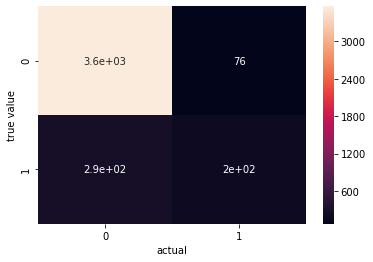

In [73]:
import seaborn as sns
sns.heatmap(confusion_mat,annot=True)
plt.xlabel('actual')
plt.ylabel('true value')
plt.show()